In [2]:
import librosa
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,Model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import numpy as np
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
#y_c,sr_c=librosa.load('chinese.wav',sr=16000)
#y_e,sr_e=librosa.load('e_trim.wav',sr=16000)
#mat_c=librosa.feature.mfcc(y=y_c,sr=sr,n_mfcc=64,n_fft=int(sr*0.025),hop_length=int(sr*0.010))
#print(y_c.shape,sr,mat_c.shape)
#mat_e=librosa.feature.mfcc(y=y_e,sr=sr,n_mfcc=64,n_fft=int(sr*0.025),hop_length=int(sr*0.010))
#print(y_e.shape,sr,mat_e.shape)

In [4]:
# each data has a sequence less than 60000
ENG_DIR='D:\\usc study\\4th semester\\EE599 Deep learning\\EE599_coding\\HW5\\train\\english\\'
HIN_DIR='D:\\usc study\\4th semester\\EE599 Deep learning\\EE599_coding\\HW5\\train\\hindi\\'
CHN_DIR='D:\\usc study\\4th semester\\EE599 Deep learning\\EE599_coding\\HW5\\train\\mandarin\\'

def load_voicedata(num_eng,num_chn,num_hin,length):
    eng_data=np.zeros((num_eng,64,length),dtype=float)
    eng_labels=np.zeros((num_eng,1),dtype=float)
    chn_data=np.zeros((num_chn,64,length),dtype=float)
    chn_labels=np.ones((num_chn,1),dtype=float)*2
    hin_data=np.zeros((num_hin,64,length),dtype=float)
    hin_labels=np.ones((num_hin,1),dtype=float)
    eng_voice = [ENG_DIR+i for i in os.listdir(ENG_DIR)]
    chn_voice = [CHN_DIR+i for i in os.listdir(CHN_DIR)]
    hin_voice = [HIN_DIR+i for i in os.listdir(HIN_DIR)]
    for i,eng_file in enumerate(eng_voice):
        read_data=np.load(eng_file)
        eng_data[i]=read_data[:,:length]
        if i==num_eng-1:
            break
    print('finished preparing english data')
    for i,chn_file in enumerate(chn_voice):
        read_data=np.load(chn_file)
        chn_data[i]=read_data[:,:length]
        if i==num_chn-1:
            break
    print('finished preparing madarin data')
    for i,hin_file in enumerate(hin_voice):
        read_data=np.load(hin_file)
        hin_data[i]=read_data[:,:length]
        if i==num_hin-1:
            break
    print('finished preparing hindi data')
    data=np.concatenate((eng_data,chn_data,hin_data),axis=0)
    labels=np.concatenate((eng_labels,chn_labels,hin_labels),axis=0)
    print('finished preparing data')
    print('data size',data.shape)
    return data,labels
    

In [131]:
data,labels=load_voicedata(60,40,20,20000)

finished preparing english data
finished preparing madarin data
finished preparing hindi data
finished preparing data
data size (120, 64, 20000)


In [134]:
def data_preprocessing(input_data,input_labels):
    data_mean_mid=input_data.mean(axis=0)
    data_mean=data_mean_mid.mean(axis=1)
    data_std_mid=input_data.std(axis=0)
    data_std=data_std_mid.std(axis=1)
    output_data=input_data
    for i in range (0,len(input_data)):
        for j in range (0,input_data.shape[2]):
            output_data[i,:,j]-=data_mean
            output_data[i,:,j]=output_data[i,:,j]/data_std
#    output_data=(input_data-data_mean)/data_std
    output_labels=np.zeros((len(input_data),3),dtype=float)
    for i in range (0,len(input_data)):
        if input_labels[i]==0:
            output_labels[i,0]=1
        elif input_labels[i]==1:
            output_labels[i,1]=1
        else:
            output_labels[i,2]=1
    print('finish data preprocessing, get standard data and one hot labels')
    return output_data,output_labels

In [132]:
all_data,all_labels=data_preprocessing(data,labels)

In [16]:
# seperate full length of 50000 sequence into a simple length, and seperate to gene_times apart, try each_length=1000(10s), generate 20 times
def data_generator(input_data,input_labels,each_length,gene_times):
    gene_data=np.zeros((len(input_data)*gene_times,64,each_length),dtype=float)
    gene_labels=np.zeros((len(input_data)*gene_times,3),dtype=float)
    for i in range (0,len(input_data)):
        for j in range (0,gene_times):
            gene_data[i*gene_times+j]=input_data[i,:,j*(each_length+100):j*(each_length+100)+each_length]
            gene_labels[i*gene_times+j]=input_labels[i]
    
    return gene_data,gene_labels
    

In [142]:
gene_data,gene_labels=data_generator(all_data,all_labels,each_length=600,gene_times=25)
train_data,val_data,train_labels,val_labels=train_test_split(gene_data,gene_labels,test_size=0.1666)
print('train size:',train_data.shape)

train size: (2500, 64, 600)


In [156]:
def show_plot():
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def get_hot_value(prediction_list):
    hot_list=np.zeros((prediction_list.shape[0],prediction_list.shape[1]),int)
    for i in range (0,len(prediction_list)):
        max_val, hot_oneline, max_found = max(prediction_list[i]), [], False
        for item in prediction_list[i]:
            if item == max_val and not max_found:
                hot_oneline.append(1)
                max_found = True
            else:
                hot_oneline.append(0)
        hot_list[i,:]=hot_oneline
    return hot_list

def detail(label,predictions):
    n_right=0
    n_wrong=0
    pred_onehot=get_hot_value(predictions)
    n_wrongclassified=np.zeros((predictions.shape[1]),int) #classified as a label(in predictions), but is not
    n_rightclassified=np.zeros((predictions.shape[1]),int)
    n_allclassified=pred_onehot.sum(axis=0)
    n_alllabeled=label.sum(axis=0)
    for i in range (0,len(predictions)):
        if (label[i]==pred_onehot[i]).all():
            n_right+=1
            n_rightclassified+=pred_onehot[i]
        else:
            n_wrong+=1
            n_wrongclassified+=pred_onehot[i]
    accuracy=n_right/len(predictions)
    return accuracy,n_wrongclassified,n_rightclassified,n_allclassified,n_alllabeled.astype(int)
def performance():
    prediction=model.predict(val_data,verbose=0)
    accu=detail(val_labels,prediction)
    print('detail of training image')
    print('for test accuracy is %f' %accu[0])
    print('wrong prediction of train label',accu[1])
    print('right prediction of train label',accu[2])
    print('prediction of train label      ',accu[3])
    print('true of train label            ',accu[4])
    show_plot()
    return prediction,accu

In [160]:
def model_GRU():
    model = Sequential()
    model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(64,gene_data.shape[-1])))
    model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(64,gene_data.shape[-1])))
    model.add(layers.Flatten())   # is flatten layer necessary?
    model.add(layers.Dense(32,activation='relu'))
#    model.add(layers.Flatten())
    model.add(layers.Dense(8,activation='relu'))
    model.add(layers.Dense(3,activation='sigmoid'))
#    model.add(Activation('sigmoid'))
    return model

def model_LSTM():
    model = Sequential()
    model.add(layers.LSTM(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(64,gene_data.shape[-1])))
    model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(64,gene_data.shape[-1])))
    model.add(layers.Flatten())
    model.add(layers.Dense(32,activation='relu'))
#    model.add(layers.Flatten())
    model.add(layers.Dense(3,activation='softmax'))
#    model.add(Activation('sigmoid'))
    return model 

model=model_LSTM()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64, 64)            170240    
_________________________________________________________________
gru_40 (GRU)                 (None, 64, 32)            9312      
_________________________________________________________________
flatten_18 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                65568     
_________________________________________________________________
dense_53 (Dense)             (None, 3)                 99        
Total params: 245,219
Trainable params: 245,219
Non-trainable params: 0
_________________________________________________________________


In [161]:
n_batch=5
n_epoch=10
#train_data_new=train_data.reshape(1200,1,1,64, 600)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')


early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 

history=model.fit(train_data,train_labels,epochs=n_epoch,batch_size=n_batch,
                    validation_split=0.2,callbacks=[history, early_stopping])

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 147s 74ms/step - loss: 1.0025 - val_loss: 1.0055
Epoch 2/10
2000/2000 [==============================] - 137s 69ms/step - loss: 0.8105 - val_loss: 0.9300
Epoch 3/10
2000/2000 [==============================] - 119s 60ms/step - loss: 0.5335 - val_loss: 0.9426
Epoch 4/10
2000/2000 [==============================] - 129s 65ms/step - loss: 0.3547 - val_loss: 0.9532
Epoch 5/10
2000/2000 [==============================] - 124s 62ms/step - loss: 0.2282 - val_loss: 0.8386
Epoch 6/10
2000/2000 [==============================] - 127s 64ms/step - loss: 0.1475 - val_loss: 1.2127
Epoch 7/10
2000/2000 [==============================] - 125s 63ms/step - loss: 0.1329 - val_loss: 1.0316
Epoch 8/10
2000/2000 [==============================] - 125s 63ms/step - loss: 0.1087 - val_loss: 1.1211
Epoch 00008: early stopping


detail of training image
for test accuracy is 0.684000
wrong prediction of train label [75 22 61]
right prediction of train label [199  45  98]
prediction of train label       [274  67 159]
true of train label             [267  80 153]


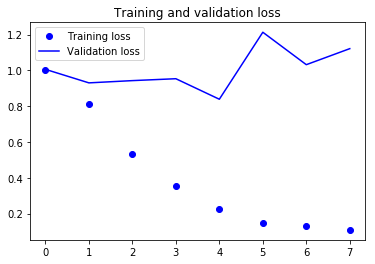

In [162]:
model_result,detail=performance()

In [163]:
for i in range (0,len(a)):
    print(model_result[i], 'vs',val_labels[i])


[0.00614844 0.9898196  0.00403208] vs [0. 1. 0.]
[0.03758283 0.315864   0.64655316] vs [0. 0. 1.]
[0.76511866 0.00985872 0.22502261] vs [1. 0. 0.]
[6.8445661e-05 9.9900144e-01 9.3005644e-04] vs [0. 1. 0.]
[0.4809006  0.51457566 0.00452375] vs [1. 0. 0.]
[0.03997739 0.22404324 0.7359794 ] vs [0. 1. 0.]
[7.3960102e-01 2.6038560e-01 1.3440699e-05] vs [0. 1. 0.]
[3.1436625e-01 3.7522134e-06 6.8562996e-01] vs [0. 0. 1.]
[9.9978238e-01 1.0946186e-06 2.1660929e-04] vs [1. 0. 0.]
[2.7309658e-02 9.7202736e-01 6.6290196e-04] vs [0. 1. 0.]
[6.5491614e-03 6.0841390e-05 9.9338996e-01] vs [1. 0. 0.]
[9.9986041e-01 9.5744932e-09 1.3952373e-04] vs [1. 0. 0.]
[9.9823582e-01 2.6774648e-04 1.4963837e-03] vs [1. 0. 0.]
[9.9977714e-01 7.0325683e-08 2.2274847e-04] vs [1. 0. 0.]
[9.9933475e-01 6.5944740e-04 5.6965596e-06] vs [1. 0. 0.]
[9.0472007e-01 9.5278449e-02 1.4772831e-06] vs [0. 1. 0.]
[9.9994683e-01 4.6153755e-06 4.8542868e-05] vs [1. 0. 0.]
[1.2616469e-02 6.2223269e-05 9.8732138e-01] vs [0. 0. 1.]
[

[9.9852979e-01 3.2065806e-04 1.1494573e-03] vs [1. 0. 0.]
[2.1135358e-03 1.0587792e-04 9.9778062e-01] vs [0. 0. 1.]
[7.2668248e-05 2.1239026e-12 9.9992728e-01] vs [0. 0. 1.]
[1.2957069e-01 7.1405157e-07 8.7042862e-01] vs [1. 0. 0.]
[4.9144799e-01 1.5855207e-06 5.0855041e-01] vs [1. 0. 0.]
[0.99073106 0.00319094 0.00607801] vs [1. 0. 0.]
[7.2304988e-01 2.7682242e-01 1.2770896e-04] vs [1. 0. 0.]
[4.0817861e-02 9.5912904e-01 5.3067331e-05] vs [0. 1. 0.]
[9.2089909e-01 1.2921384e-07 7.9100825e-02] vs [0. 1. 0.]
[5.6434952e-02 2.9458615e-05 9.4353563e-01] vs [1. 0. 0.]
[0.74856675 0.10814527 0.14328799] vs [1. 0. 0.]
[0.48667622 0.13864185 0.37468195] vs [1. 0. 0.]
[9.8936951e-01 1.0581704e-02 4.8711961e-05] vs [1. 0. 0.]
[9.9914324e-01 3.0408698e-04 5.5268110e-04] vs [1. 0. 0.]
[3.4797618e-03 2.1820028e-06 9.9651802e-01] vs [0. 0. 1.]
[0.70422846 0.2282903  0.06748125] vs [0. 0. 1.]
[6.1236247e-02 9.3803447e-01 7.2925311e-04] vs [0. 1. 0.]
[1.5457565e-05 1.8431408e-07 9.9998438e-01] vs [0.

In [164]:
model.save('hw5_LSTM.h5')